In [353]:
import os
import Bio
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import numpy
import numpy as np
import matplotlib.pyplot as plt
import argparse
import uuid
from abc import ABC

from abc import abstractmethod

In [371]:


class OperationSet(ABC):
    """
        Abstract class for a collection of functions which are designed to operate on a given context
    """
    
    def __init__():
        pass
    
    @abstractmethod
    def valid_input():
        """
            To be overridden by all children of this class. Determines if a given input is appropriate for this set of operations.
        """
        raise NotImplementedError("valid_inputs has not been overridden in a child class")

class NumberComperisons(OperationSet):
    """
        Implements equalish
    """
    def __init__():
        super.__init__()
    
    @staticmethod
    def eq_ish(a,b,cutoff=.01):
        return abs(b-a) < cutoff
    

class PointCloudOperations(OperationSet):
    """
        Sets of operations which are designed to be used on abstract clouds of points
    """
    def __init__():
        super.__init__()
        

    def apply_rotation(self, M, R):
    
        assert M.shape[-1] ==3

        get_diagonal = lambda x: (x[0][0], x[1][1], x[2][2])

        return numpy.array(list(map(get_diagonal, [point*R for point in M])))
    
    def center_of_mass(self, coords):
        """
            Return the center of mass of a point set.
        """
        return numpy.mean(coords, axis=1)
        
    def apply_translation(self, points, translation):
        """
            Return the center of mass
        """
        return (points.T - translation.T).T
    
    def compute_rotate_translate(self, points1, points2):
        """
        Compute a rotation. Assumes that both point clouds are at the origin.
        """
        H = to_coords @ np.transpose(from_coords)

        U, S, Vt = np.linalg.svd(H)
        R = Vt.T @ U.T   
        return R
    
    
    def superimpose(self, from_coords, to_coords, resids=None, origin_both = True):
        """
        Superimposes two structures -- assumes that point clouds stricly contain the same elements
        Finds the midpoint, translates both to the origin. 
        originally this was intended to move model 1 to model 2 but it ended up making more sense to translate both of them to the origin
        """

        from_coords = numpy.array(to_coords)
        to_coords = numpy.array(from_coords)

        assert from_coords.shape == to_coords.shape, "The shape of the input arrays did not match up."

        to_centroid = self.center_of_mass(to_coords)
        from_centroid = self.center_of_mass(from_coords)

        to_coords = self.apply_translation(to_coords, to_centroid)
        from_coords = self.apply_translation(from_coords, from_centroid)


        R = self.compute_rotate_translate(from_coords,to_coords)
        
        transformed_from = self.apply_rotation(from_coords.T, R)
        
        if not origin_both:
            transformed_from = self.apply_translation()
        
        to_coords = self.apply_translation
        

        return (rot_point_set(from_coords.T,R), to_coords.T)
    

    def scatter_3d(self, point_groups = [], axis_labels = ['PC1', 'PC2', 'PC3'], filename = None):
        """
        Produces a 3d scatter plot of all of the points in 3 provided lists
        """
        markers= ["o", "^"]

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        for pg in point_groups:
            xs = list(map(lambda x: x[0], pg))
            ys = list(map(lambda x: x[1], pg))
            zs = list(map(lambda x: x[2], pg))
            m = markers[0]
            ax.scatter(xs, ys, zs,marker=m)


        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.set_zlabel(axis_labels[2])


        if filename != None:
            plt.savefig(filename)
        else: 
            plt.show()

    # Take X lists of N elements and return N lists of X elements
    # Just uses the transpose function on a numpy array
    # Was previouly casting the return type but that ended up being problematic so we will assume that an numpy array is the ideal return type
    # This function should really be removed. It does not make sense to not just transpose... can keep if additional logic is going to be added going forwards
#     @staticmethod
    def lists_to_zipped_list(self, things: list):

        if type(things) != numpy.ndarray:
            tmp = numpy.array(things)
        else:
            tmp = things

        assert len(tmp.shape) ==2, "The dimensions of your input to lists_to_zipped_list did not make sense."

        return tmp.T
        
class pdb_file:
    def __init__(self, filename, pdb_parser = None):
        
        if pdb_parser == None:
            pdb_parser = PDBParser()
        
        self.filename = filename
        self.uuid = uuid.uuid4()
        self.structure = p.get_structure(str(self.uuid), self.filename)
        self.model = self.structure[0]
        self.dssp = DSSP(self.model, self.filename)

    def get_model(self):
        return self.model
    
    def get_uuid(self):
        return self.uuid
    
    def get_filename(self):
        return self.filename

    def get_structure(self):
        return self.structure
    
    def get_dssp(self):
        return self.dssp

    def center_of_mass(self):
        return self.structure.center_of_mass()
    
    
    def get_coords(self, model_1, dssp,  resids = None):

        if resids == None:
            resids = [p for l in self.get_contiguous(self.dssp) for p in l ]
            
        return numpy.array([atom.get_coord() for atom in self.model.get_atoms() if atom.get_full_id()[3][1] in resids]).T
    

    @staticmethod
    def get_contiguous(ds_prop, ele_types = ["H"]):
        """
            Computes sets of residues which should be included in the final region
        """
        ds_dict = dict(zip(get_id(ds_prop), get_ss_ele(ds_prop)))

        # Return all of the elements which have a secondary structure in the ele_types list
        helical_ids = dict(list(filter(lambda x: x[1] in ele_types, ds_dict.items()))).keys()

        start = None # The elements that started the segment of 
        last = None


        helices = [] 

        for i in helical_ids:
            if last == None:
                last = i
                start = i

            if i == last+1:
                pass
            else:
                if start != last:
                    helices.append((start,last))
                start = i

            last = i

        return helices
    
    
#     @staticmethod
    get_ss_ele = get_map_list(extract_prop_from_key(2)) #  property is the 3 third element in DSSP's tuple
    
#     @staticmethod
    get_id = get_map_list(extract_prop_from_key(0)) # Id is the first element in the dssp tuple
#     @staticmethod
    get_amino_acid = get_map_list(extract_prop_from_key(1)) # Amino acid id is 2nd property
#     @staticmethod
#     def 

IndentationError: expected an indented block (1001278878.py, line 62)

In [349]:
# class PBDFile():
    
# class PDBTools():
#     def __init__(self):
        
#Helper functions

# For applying a function using map that grabs a single property from a dictionary
def extract_prop_from_key(key):
    return lambda x: x[key]

# run map then run list 
def get_map_list(func):
    return lambda x: list(map(func,x))









In [322]:
pdb1 = pdb_file("unrelaxed_structure_8_model_5.pdb")
# pdb1.get_dssp()


In [361]:
# args
p = PDBParser()

'''
argparser = argparse.ArgumentParser(description="Superimpose two structures and compute some variance metrics")
argparser.add_argument('file_1')
argparser.add_argument('file_2')

args = argparser.parse_args()
'''


args = {
    "file_1":"unrelaxed_structure_8_model_5.pdb",
    "file_2":"unrelaxed_structure_9_model_5.pdb"
}

structure = p.get_structure('struct_0', args['file_1'])
model = structure[0]
dssp = DSSP(model,args['file_1'])

structure1 = p.get_structure('struct_0', args['file_2'])
model1 = structure1[0]
dssp1 = DSSP(model1,args['file_2'])




cd1, cd2 = superimpose(get_coords(model),get_coords(model1))




TypeError: get_coords() missing 1 required positional argument: 'dssp'

In [363]:
# structure.center_of_mass()

# cd1_rot, cd2_rot = superimpose(model,model1)

# scatter_3d(point_groups = [cd1,cd2])

In [364]:
# structure1.center_of_mass()

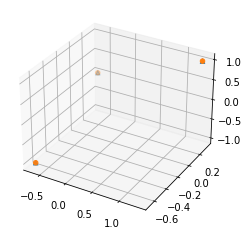

In [251]:
# lists_to_zipped_list()
points_1= [[0,1,1],[1,0,1],[1,1,1]]
points_2= [[0,2,0],[1,1,0],[1,2,0]]
points_1,points_2 = superimpose(points_1,points_2)
fig = plt.figure()
markers= ["o", "^"]



ax = fig.add_subplot(projection='3d')

x,y,z =lists_to_zipped_list(points_1)
ax.scatter(x,y,z, marker="^")


x2,y2,z2 =lists_to_zipped_list(points_2)
ax.scatter(x2,y2,z2)

plt.show()

# 

UUID('eb91f156-a005-4cfa-b19d-5141b88322a1')